<a href="https://colab.research.google.com/github/eduval91/CSV_files/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC
from scipy.stats import ttest_ind,chi2_contingency

In [2]:
from datetime import datetime
print(f"Run time: {datetime.now().strftime('%D %T')}")

Run time: 05/23/25 01:26:48


#Loading Data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/eduval91/CSV_files/refs/heads/main/heart_disease.csv')
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,target_binary
0,63.000000,1,1,145.000000,233.000000,1,2,150.000000,0,2.300000,3,0.0,6.0,0,0
1,67.000000,1,4,160.000000,286.000000,0,2,108.000000,1,1.500000,2,3.0,3.0,2,1
2,67.000000,1,4,120.000000,229.000000,0,2,129.000000,1,2.600000,2,2.0,7.0,1,1
3,37.000000,1,3,130.000000,250.000000,0,0,187.000000,0,3.500000,3,0.0,3.0,0,0
4,41.000000,0,2,130.000000,204.000000,0,2,172.000000,0,1.400000,1,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,60.072205,1,3,115.422056,181.768595,0,0,128.155858,1,1.001941,2,1.0,7.0,2,1
1020,70.928404,1,2,166.727221,244.993631,1,0,108.481311,0,0.698337,2,1.0,7.0,2,1
1021,57.332875,1,2,105.075177,233.146324,0,2,140.342007,0,1.519138,1,0.0,7.0,2,1
1022,40.881554,0,4,125.068578,154.370678,1,2,123.756294,0,1.936684,2,1.0,7.0,2,1


# Examine Data

In [4]:
df.isna().sum()

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [5]:
dup_count = df.duplicated().sum()
print(f'Number of duplicate rows: {dup_count}')

Number of duplicate rows: 0


In [6]:
df.shape

(1024, 15)

In [7]:
#dropping num column as we already have the target binary
df.drop('num',axis=1, inplace=True)

**There are no duplicate rows or missing values**

---



## Separate independent and dependent variables

In [8]:
#indepedent variables: all columns except target
X = df.drop('target_binary', axis =1)

#depedent variable: target
y = df['target_binary']

In [9]:
X.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1,1,145.0,233.0,1,2,150.0,0,2.3,3,0.0,6.0
1,67.0,1,4,160.0,286.0,0,2,108.0,1,1.5,2,3.0,3.0
2,67.0,1,4,120.0,229.0,0,2,129.0,1,2.6,2,2.0,7.0
3,37.0,1,3,130.0,250.0,0,0,187.0,0,3.5,3,0.0,3.0
4,41.0,0,2,130.0,204.0,0,2,172.0,0,1.4,1,0.0,3.0


In [10]:
y.shape

(1024,)

In [11]:
y.head()

,target_binary
0,0
1,1
2,1
3,0
4,0


###Visuals for further exploratory analysis of features

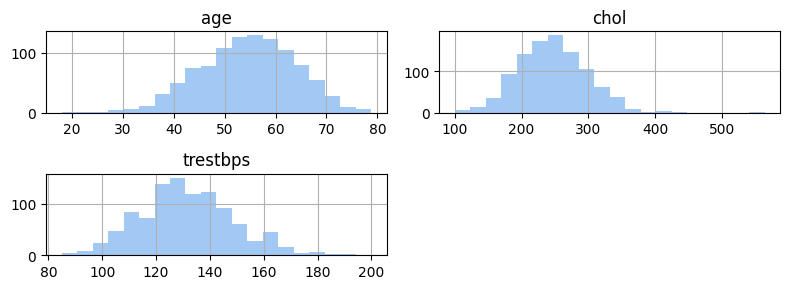

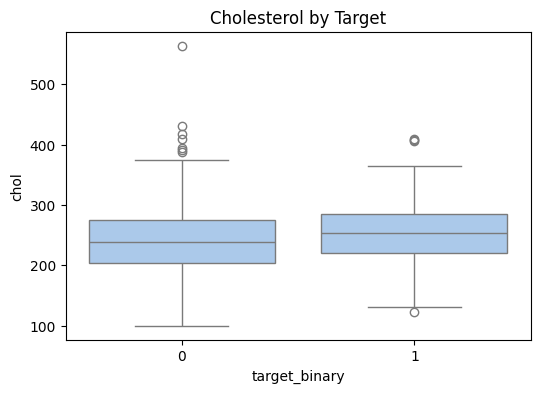

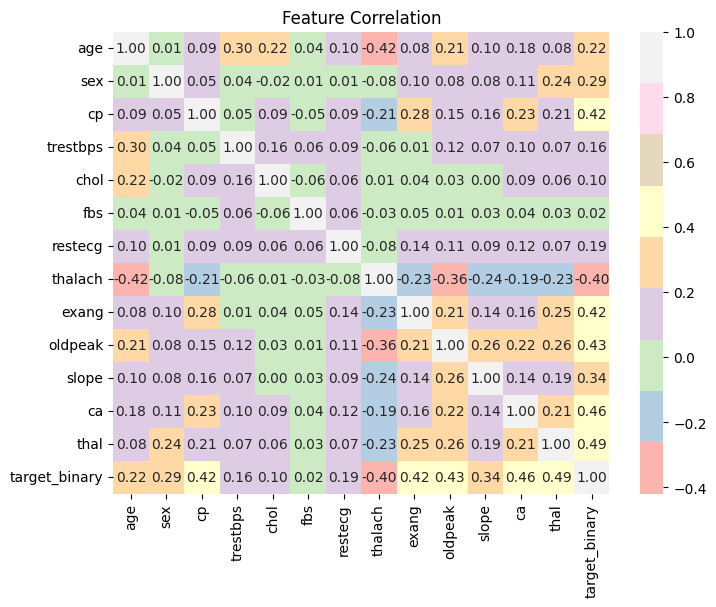

In [12]:
sns.set_palette('pastel')
df[['age','chol','trestbps']].hist(bins=20, figsize=(8,3))
plt.tight_layout()

plt.figure(figsize=(6,4))
sns.boxplot(x=y, y=df['chol'])
plt.title('Cholesterol by Target')
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='Pastel1')
plt.title('Feature Correlation')
plt.show()

# Split data into training and tests sets

In [13]:
#Defining Global Variables
global TEST_SIZE, RANDOM_STATE
TEST_SIZE = .30
RANDOM_STATE = 42

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = RANDOM_STATE)

In [15]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(include_bias=False)),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE)),],memory='cache_folder')

param_grid = {
    'poly__degree':           [1, 2, 3],
    'poly__interaction_only': [True, False],
    'rf__n_estimators':       [100, 300],
     'rf__max_depth':          [None, 5, 10]
}

In [16]:
grid = GridSearchCV(
    pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print('Best CV score:', grid.best_score_)
print('Best params:  ', grid.best_params_)
print('Test score:   ', grid.score(X_test, y_test))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best CV score: 0.8980477855477854
Best params:   {'poly__degree': 1, 'poly__interaction_only': True, 'rf__max_depth': 5, 'rf__n_estimators': 100}
Test score:    0.8701298701298701


**Grid Search results are showing that no polynomial expansion improved performance.**


#Train Random Forest Classifier

In [17]:
#Random Forest Classifier model
RF_model = RandomForestClassifier(n_estimators=1000,random_state=RANDOM_STATE,max_depth=5)
RF_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=42)

In [18]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [19]:
RF_prob = RF_model.predict(X_test)
RF_accuracy = accuracy_score(y_test, RF_prob)
RF_prec = precision_score(y_test, RF_prob)
RF_rec  = recall_score( y_test, RF_prob)
print(f'Accuracy: {RF_accuracy*100:.2f}%')
print(f'Precision: {RF_prec:.3f}')
print(f'Recall:    {RF_rec:.3f}')

Accuracy: 87.66%
Precision: 0.869
Recall:    0.856


#Standardize Data for Models

In [20]:
scaler = StandardScaler()
X_train_sca = scaler.fit_transform(X_train)
X_test_sca = scaler.transform(X_test)

# Train Logistic Regression Model

In [21]:
log_model = LogisticRegression()

In [22]:
log_model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
log_model.fit(X_train_sca, y_train)

LogisticRegression()

In [24]:
LogReg_predictions = log_model.predict(X_test_sca)
LogReg_accuracy = accuracy_score(y_test, LogReg_predictions)
LogReg_prec = precision_score(y_test, LogReg_predictions)
LogReg_rec  = recall_score( y_test, LogReg_predictions)
print(f'Accuracy: {LogReg_accuracy*100:.2f}%')
print(f'Precision: {LogReg_prec:.3f}')
print(f'Recall:    {LogReg_rec:.3f}')

Accuracy: 87.01%
Precision: 0.846
Recall:    0.871


#Train KNN

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=20, weights='distance')
knn_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 20,
 'p': 2,
 'weights': 'distance'}

In [26]:
knn_model.fit(X_train_sca, y_train)

KNeighborsClassifier(n_neighbors=20, weights='distance')

In [27]:
KNN_pred = knn_model.predict(X_test_sca)
KNN_accuracy = accuracy_score(y_test, KNN_pred)
KNN_prec = precision_score(y_test, KNN_pred)
KNN_rec  = recall_score( y_test, KNN_pred)
print(f'Accuracy: {KNN_accuracy*100:.2f}%')
print(f'Precision: {KNN_prec:.3f}')
print(f'Recall:    {KNN_rec:.3f}')

Accuracy: 87.34%
Precision: 0.862
Recall:    0.856


#Support Vector Machine Model & Accuracy

In [28]:
classifiers = [
    SVC(C=0.5, kernel='poly', class_weight='balanced', probability=True,
        break_ties=True,random_state=RANDOM_STATE),
    LinearSVC(dual=False, C=0.5, multi_class='ovr', max_iter=1000,random_state=RANDOM_STATE),
    NuSVC(nu=0.5, kernel='sigmoid',class_weight='balanced', probability=True,
        break_ties=True, random_state=RANDOM_STATE)
    ]

for classifier in classifiers:
    print()
    print(classifier)
    model = classifier.fit(X_train_sca, y_train)
    svm_model_preds = model.predict(X_test_sca)
    svm_model_accuracy = accuracy_score(y_test, svm_model_preds)
    print(f'Accuracy: {svm_model_accuracy*100:.2f}%')
    print(f'Precision: {precision_score(y_test, svm_model_preds):.3f}')
    print(f'Recall:    {recall_score(y_test, svm_model_preds):.3f}')


SVC(C=0.5, break_ties=True, class_weight='balanced', kernel='poly',
    probability=True, random_state=42)
Accuracy: 87.01%
Precision: 0.861
Recall:    0.849

LinearSVC(C=0.5, dual=False, random_state=42)
Accuracy: 87.34%
Precision: 0.852
Recall:    0.871

NuSVC(break_ties=True, class_weight='balanced', kernel='sigmoid',
      probability=True, random_state=42)
Accuracy: 87.66%
Precision: 0.858
Recall:    0.871


##Model Accuracy Graph

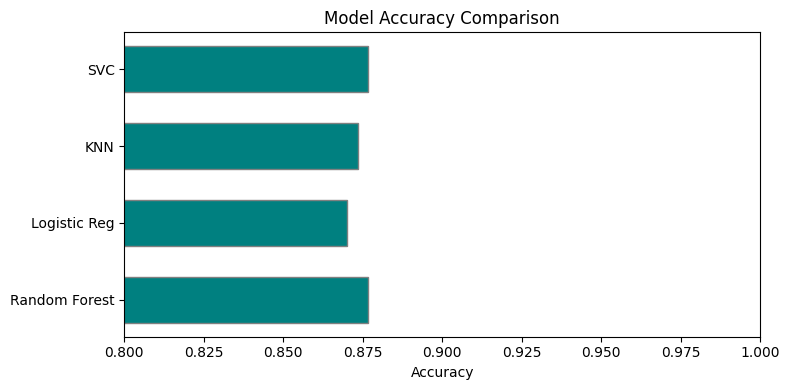

In [29]:
models = ['Random Forest', 'Logistic Reg', 'KNN', 'SVC']
accuracies = [RF_accuracy, LogReg_accuracy, KNN_accuracy, svm_model_accuracy]

y_pos = range(len(models))

plt.figure(figsize=(8, 4))
plt.barh(y_pos, accuracies, color='teal', edgecolor='gray', height=0.6)
plt.yticks(y_pos, models)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0.8, 1.0)
plt.tight_layout()
plt.show()

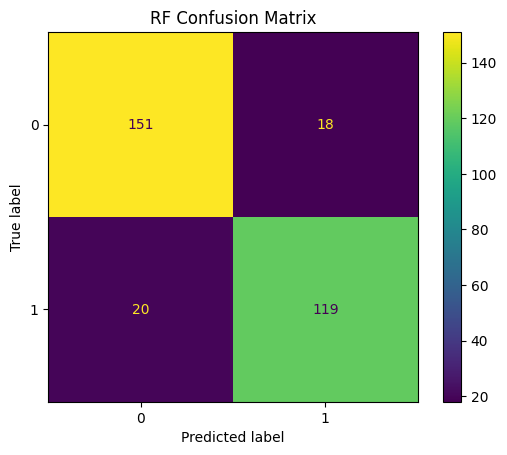

In [30]:
con_mat1 = confusion_matrix(y_test, RF_prob)
ConfusionMatrixDisplay(con_mat1, display_labels=RF_model.classes_).plot()
plt.title('RF Confusion Matrix')
plt.show()

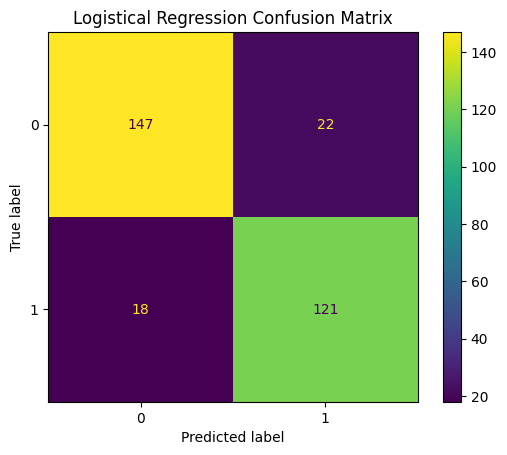

In [31]:
con_mat2 = confusion_matrix(y_test, LogReg_predictions)
ConfusionMatrixDisplay(con_mat2, display_labels=log_model.classes_).plot()
plt.title('Logistical Regression Confusion Matrix')
plt.show()

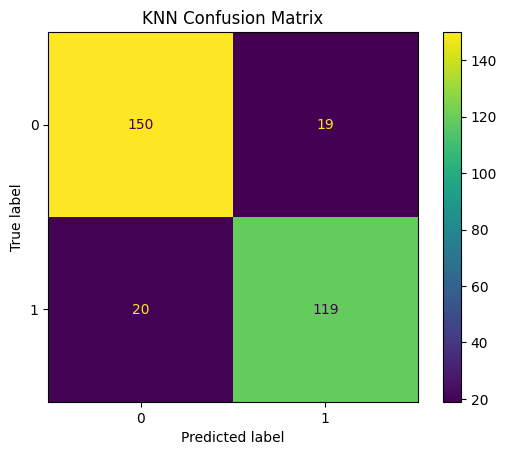

In [32]:
con_mat = confusion_matrix(y_test, KNN_pred)
ConfusionMatrixDisplay(con_mat, display_labels=knn_model.classes_).plot()
plt.title('KNN Confusion Matrix')
plt.show()

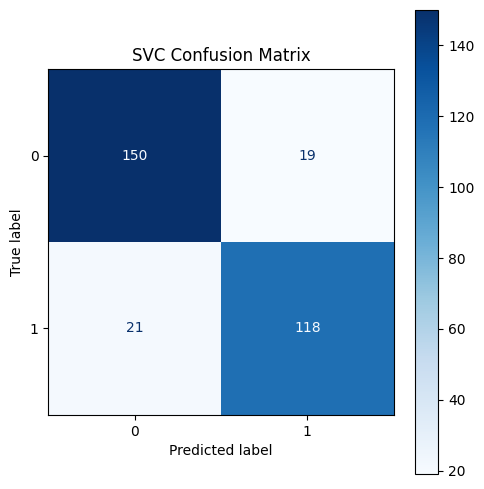

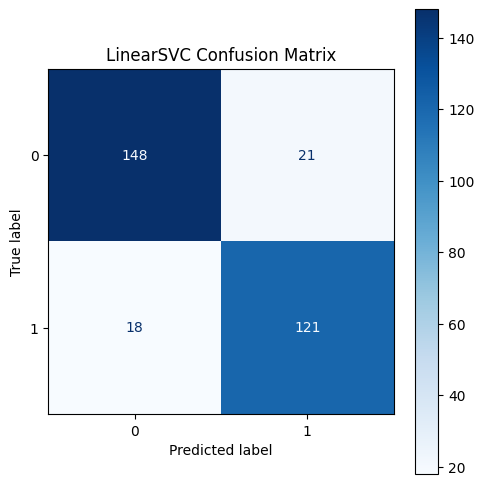

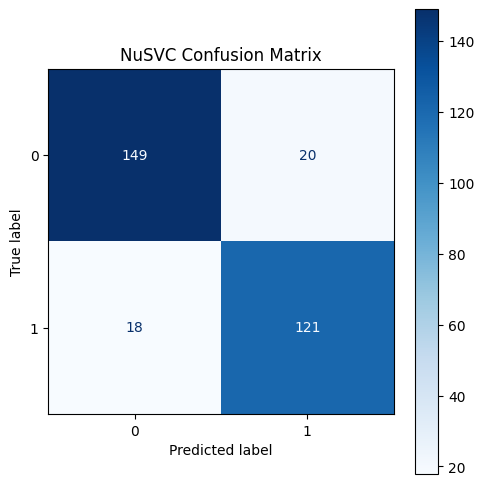

In [33]:
for classifier in classifiers:

    classifier.fit(X_train_sca, y_train)
    y_pred = classifier.predict(X_test_sca)
    cm = confusion_matrix(y_test, y_pred)


    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=classifier.classes_
    )
    fig, ax = plt.subplots(figsize=(5, 5))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    ax.set_title(f"{classifier.__class__.__name__} Confusion Matrix")
    plt.tight_layout()
    plt.show()

#Feature Importance


In [34]:
result = permutation_importance(
    knn_model,
    X_test_sca,
    y_test,
    n_repeats=30,
    random_state=RANDOM_STATE,
    scoring='accuracy'
)

In [35]:
importances = result.importances_mean
stds        = result.importances_std
feature_names = X.columns if hasattr(X, 'columns') else [f"f{i}" for i in range(X.shape[1])]
indices = np.argsort(importances)[::-1]

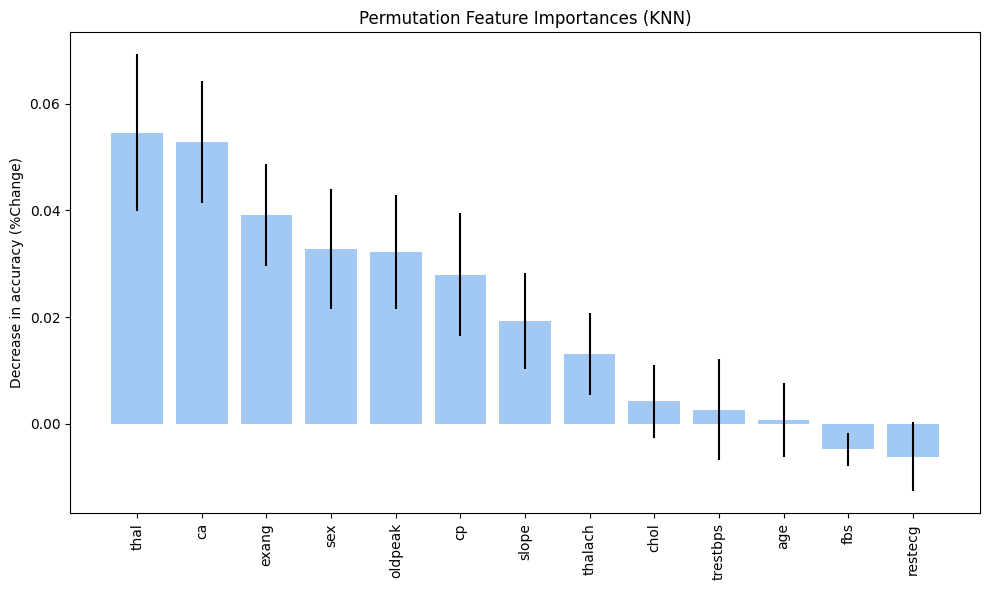

In [36]:
plt.figure(figsize=(10,6))
plt.bar(
    range(len(importances)),
    importances[indices],
    yerr=stds[indices],
    align='center'
)
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.ylabel("Decrease in accuracy (%Change)")
plt.title("Permutation Feature Importances (KNN)")
plt.tight_layout()
plt.show()

#Testing Hypothesis
#               H0:P(positive∣male,age<53)=P(positive∣male,age<u>></u>53)


---


#               H1:P(positive|male,age<u>></u>53)>P(positive|male,age<53)

In [37]:
#df with men filtered
men = df.loc[X_test.index].copy()
men['age'] = X_test['age']
men['Age 53+'] = (X_test['age'] >= 53).astype(int)
men['KNN_pred'] = KNN_pred
men['target_binary'] = y_test.values

In [38]:
#confirming age bucket is filtered correctly
print(men.groupby('Age 53+')['age']
           .agg(['min','max','count'])
           .sort_index())

               min        max  count
Age 53+                             
0        31.665121  52.983450    126
1        53.000000  75.645721    182


In [39]:
men['age'].count()

np.int64(308)

In [40]:
men.head(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target_binary,Age 53+,KNN_pred
525,52.627323,1,2,130.910945,274.841191,1,0,172.713869,1,0.621450,2,0.0,3.0,0,0,0
357,67.294140,1,1,118.211487,236.896391,0,0,151.417279,0,2.562499,1,0.0,3.0,0,1,0
444,62.177437,1,4,123.863236,248.430360,0,2,149.730541,0,1.219966,1,0.0,3.0,0,1,0
31,60.000000,1,4,117.000000,230.000000,1,0,160.000000,1,1.400000,1,2.0,7.0,1,1,1
618,46.144119,0,3,97.727231,305.458561,0,2,176.124851,0,0.000000,2,0.0,3.0,0,0,0


In [41]:
probs_under = men.loc[men['Age 53+']==0, 'KNN_pred']
probs_over  = men.loc[men['Age 53+']==1, 'KNN_pred']

tstat, pval = ttest_ind(probs_over, probs_under, equal_var=False)
print(f'T-statistic: {tstat:.3f}, p-value: {pval:.3f}')

T-statistic: 2.469, p-value: 0.014


In [42]:
actual_rates = men.groupby('Age 53+')['target_binary'].mean()
print('Observed positive rate:\n', actual_rates)

Observed positive rate:
 Age 53+
0    0.357143
1    0.516484
Name: target_binary, dtype: float64


##We successfully reject the null hypothesis and can conclude that men over 53 are more likely to be diagnosed with heart disease.





##Further Testing with Random Forest Classifier

In [43]:
#Using Random Forest Model
men['RF_prob'] = RF_prob


In [44]:
men['RF_prob'] = RF_model.predict_proba(X_test_sca)[:,1]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [45]:
probs_young = men.loc[men['Age 53+']==0, 'RF_prob']
probs_old  = men.loc[men['Age 53+']==1, 'RF_prob']

tstat2, pval2 = ttest_ind(probs_old, probs_young, equal_var=False)
print(f'T-statistic: {tstat2:.3f}, p-value: {pval2:.3f}')

T-statistic: 1.068, p-value: 0.286


In [46]:
cont = pd.crosstab(men['Age 53+'], men['target_binary'])
chi2, p_chi, _, _ = chi2_contingency(cont)
print(f"Chi²: {chi2:.3f}, p-value: {p_chi:.3f}")

print("\nObserved disease rates by Age53:\n", men.groupby('Age 53+')['target_binary'].mean())

Chi²: 7.004, p-value: 0.008

Observed disease rates by Age53:
 Age 53+
0    0.357143
1    0.516484
Name: target_binary, dtype: float64


##We can conclude that heart disease is more prevelant in older men, however, age is not much of a factor. We will further break down positive rates within different age buckets.





In [47]:
bins = [men['age'].min()-1, 40, 50,60, 70, men['age'].max()+1]
labels = ['≤40','41–50','51–60','61–70','>70']

Observed positive rate:
 age_group
≤40      0.181818
41–50    0.318841
51–60    0.544000
61–70    0.500000
>70      0.375000
Name: target_binary, dtype: float64


<ipython-input-48-67def40accc1>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rates=men.groupby('age_group')['target_binary'].mean()


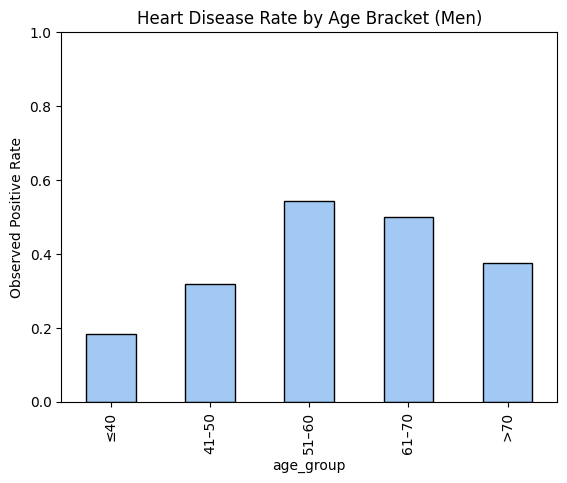

In [48]:
men['age_group'] = pd.cut(men['age'], bins=bins, labels=labels, include_lowest=True)
rates=men.groupby('age_group')['target_binary'].mean()
print('Observed positive rate:\n', rates)

rates.plot(kind='bar', edgecolor='k')
plt.ylabel('Observed Positive Rate')
plt.title('Heart Disease Rate by Age Bracket (Men)')
plt.ylim(0,1)
plt.show()

# Logistical Regression for Cholesterol Level for Heart Disease

In [49]:
#Copying dataframe for Logistical Regression
logisticaldf = df.copy()
logisticaldf

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target_binary
0,63.000000,1,1,145.000000,233.000000,1,2,150.000000,0,2.300000,3,0.0,6.0,0
1,67.000000,1,4,160.000000,286.000000,0,2,108.000000,1,1.500000,2,3.0,3.0,1
2,67.000000,1,4,120.000000,229.000000,0,2,129.000000,1,2.600000,2,2.0,7.0,1
3,37.000000,1,3,130.000000,250.000000,0,0,187.000000,0,3.500000,3,0.0,3.0,0
4,41.000000,0,2,130.000000,204.000000,0,2,172.000000,0,1.400000,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,60.072205,1,3,115.422056,181.768595,0,0,128.155858,1,1.001941,2,1.0,7.0,1
1020,70.928404,1,2,166.727221,244.993631,1,0,108.481311,0,0.698337,2,1.0,7.0,1
1021,57.332875,1,2,105.075177,233.146324,0,2,140.342007,0,1.519138,1,0.0,7.0,1
1022,40.881554,0,4,125.068578,154.370678,1,2,123.756294,0,1.936684,2,1.0,7.0,1


In [50]:
# Confirm no values are missing
missing_vals = logisticaldf.isnull().sum()
missing_vals

,0
age,0
sex,0
cp,0
trestbps,0
chol,0
fbs,0
restecg,0
thalach,0
exang,0
oldpeak,0


In [51]:
# Assign X for all other variables and y as target
X = logisticaldf.drop('target_binary', axis=1)
y = logisticaldf['target_binary']

# Logistical Training

In [52]:
# Test train using the global variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [53]:
# Scaler for cholesterol testing
scaler2 = StandardScaler()
X_train_sca2 = scaler2.fit_transform(X_train)
X_test_sca2 = scaler2.transform(X_test)

In [54]:
model = LogisticRegression(random_state=RANDOM_STATE)
model.fit(X_train_sca2, y_train)

LogisticRegression(random_state=42)

In [55]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# Logistic Regression accuracy, precision and recall

In [56]:
# Print model accuracy, precision and recall for Logistic Regression
Log_predictions = model.predict(X_test_sca2)
Log_accuracy = accuracy_score(y_test, Log_predictions)
Log_prec = precision_score(y_test, Log_predictions)
Log_rec  = recall_score( y_test, Log_predictions)
print(f'Logistic Regression Accuracy: {Log_accuracy*100:.2f}%')
print(f'Logistic Regression Precision: {Log_prec:.3f}')
print(f'Logistic Regression Recall:    {Log_rec:.3f}')

Logistic Regression Accuracy: 87.01%
Logistic Regression Precision: 0.846
Logistic Regression Recall:    0.871


# Create test groups with parameters chol<=140, chol>140, chol<=160 and chol >160

In [57]:
# Create first test group plug in chol <= 140 and chol >140 to determine heart disease
low_chol_group = logisticaldf[logisticaldf['chol'] <= 140]
low_chol_group

#This is a different range test group using chol <= 160
low_chol_group2 = logisticaldf[logisticaldf['chol'] <= 160]
low_chol_group2

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target_binary
93,44.000000,0,3,108.000000,141.000000,0,0,175.000000,0,0.600000,2,0.0,3.0,0
169,45.000000,0,2,112.000000,160.000000,0,0,138.000000,0,0.000000,2,0.0,3.0,0
202,57.000000,1,3,150.000000,126.000000,1,0,173.000000,0,0.200000,1,1.0,7.0,0
232,49.000000,1,3,118.000000,149.000000,0,2,126.000000,0,0.800000,1,3.0,3.0,1
273,71.000000,0,4,112.000000,149.000000,0,0,125.000000,0,1.600000,2,0.0,3.0,0
295,41.000000,1,2,120.000000,157.000000,0,0,182.000000,0,0.000000,1,0.0,3.0,0
300,57.000000,1,4,130.000000,131.000000,0,0,115.000000,1,1.200000,2,1.0,7.0,1
304,29.869325,1,3,125.352466,130.481486,0,0,183.287339,0,0.433398,2,0.0,3.0,0
341,57.321440,1,3,126.527833,140.515330,0,0,149.203433,0,0.661429,1,0.0,3.0,0
413,47.000597,0,2,111.007318,124.844392,0,0,152.894109,0,0.000000,1,1.0,3.0,0


In [58]:
# Second test group
high_chol_group = logisticaldf[logisticaldf['chol'] > 140]
high_chol_group

#This is a different range test group using chol > 160
high_chol_group2 = logisticaldf[logisticaldf['chol'] > 160]
high_chol_group2

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target_binary
0,63.000000,1,1,145.000000,233.000000,1,2,150.000000,0,2.300000,3,0.0,6.0,0
1,67.000000,1,4,160.000000,286.000000,0,2,108.000000,1,1.500000,2,3.0,3.0,1
2,67.000000,1,4,120.000000,229.000000,0,2,129.000000,1,2.600000,2,2.0,7.0,1
3,37.000000,1,3,130.000000,250.000000,0,0,187.000000,0,3.500000,3,0.0,3.0,0
4,41.000000,0,2,130.000000,204.000000,0,2,172.000000,0,1.400000,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,54.863644,1,4,129.544971,234.235449,0,2,148.687647,1,0.353434,2,2.0,7.0,1
1019,60.072205,1,3,115.422056,181.768595,0,0,128.155858,1,1.001941,2,1.0,7.0,1
1020,70.928404,1,2,166.727221,244.993631,1,0,108.481311,0,0.698337,2,1.0,7.0,1
1021,57.332875,1,2,105.075177,233.146324,0,2,140.342007,0,1.519138,1,0.0,7.0,1


# Testing against hypothesis
H0​: P(HD∣cholesterol>140)=P(HD∣cholesterol≤140)

H1: P(HD∣cholesterol>140)>P(HD∣cholesterol≤140)

# Included further testing using cholesterol of 160 with same hypothesis standards

In [59]:
# Prepare the test groups for predictions using chol <=140 and chol >140
X_chol_test_group = low_chol_group.drop('target_binary', axis=1)
y_chol_test_group = low_chol_group['target_binary']

X_chol_test_group2 = high_chol_group.drop('target_binary', axis=1)
y_chol_test_group2 = high_chol_group['target_binary']

# Test groups for predictions using chol <=160 and chol >160
X_chol_test_group3 = low_chol_group2.drop('target_binary', axis=1)
y_chol_test_group3 = low_chol_group2['target_binary']

X_chol_test_group4 = high_chol_group2.drop('target_binary', axis=1)
y_chol_test_group4 = high_chol_group2['target_binary']

# Generate predictions for the first test group
y_pred_group1 = model.predict(X_chol_test_group)
accuracy_group1 = model.score(X_chol_test_group, y_chol_test_group)
print("Accuracy for cholestrol <= 140:", round((accuracy_group1 * 100), 2), "%")

# Generate predictions for the second test group
y_pred_group2 = model.predict(X_chol_test_group2)
accuracy_group2 = model.score(X_chol_test_group2, y_chol_test_group2)
print("Accuracy for cholestrol > 140:", round((accuracy_group2 * 100), 2), "%")

# Generate predictions for the third test group
y_pred_group3 = model.predict(X_chol_test_group3)
accuracy_group3 = model.score(X_chol_test_group3, y_chol_test_group3)
print("Accuracy for cholestrol <= 160:", round((accuracy_group3 * 100), 2), "%")

# Generate predictions for the fourth test group
y_pred_group4 = model.predict(X_chol_test_group4)
accuracy_group4 = model.score(X_chol_test_group4, y_chol_test_group4)
print("Accuracy for cholestrol > 160:", round((accuracy_group4 * 100), 2), "%")


Accuracy for cholestrol <= 140: 81.25 %
Accuracy for cholestrol > 140: 68.75 %
Accuracy for cholestrol <= 160: 75.0 %
Accuracy for cholestrol > 160: 68.7 %


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has fe

We would reject the null hypothesis and accept the alternative hypothesis

# Logistical Regression Confusion Matrix for Cholesterol

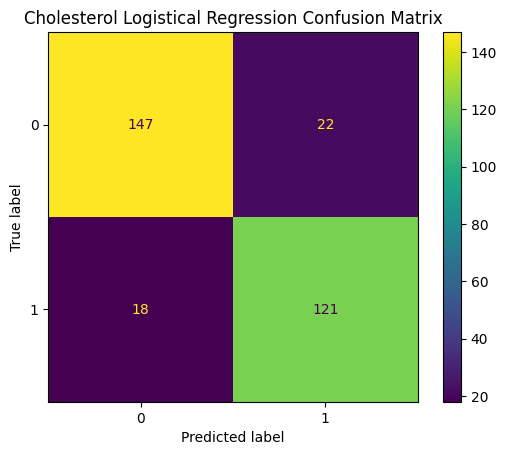

In [60]:
chol_log_matrix = confusion_matrix(y_test, LogReg_predictions)
ConfusionMatrixDisplay(chol_log_matrix, display_labels=log_model.classes_).plot()
plt.title('Cholesterol Logistical Regression Confusion Matrix')
plt.show()

# K-Nearest Neighbor for Cholesterol

In [61]:
knn = KNeighborsClassifier(n_neighbors=8)
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 8,
 'p': 2,
 'weights': 'uniform'}

In [62]:
knn.fit(X_train_sca2, y_train)

KNeighborsClassifier(n_neighbors=8)

# Evaluate performance for KNeighborsClassifier (with default hyperparameters)

In [63]:
y_pred = knn.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


# KNN accuracy, precision and recall

In [64]:
# Display model accuracy score
KNN_pred = knn.predict(X_test_sca2)
KNN_accuracy = accuracy_score(y_test, KNN_pred)
KNN_prec = precision_score(y_test, KNN_pred)
KNN_rec  = recall_score( y_test, KNN_pred)
print(f'KNN Accuracy: {KNN_accuracy*100:.2f}%')
print(f'KNN Precision: {KNN_prec:.3f}')
print(f'KNN Recall:    {KNN_rec:.3f}')

KNN Accuracy: 87.34%
KNN Precision: 0.879
KNN Recall:    0.835


# KNN Confusion Matrix for Cholesterol

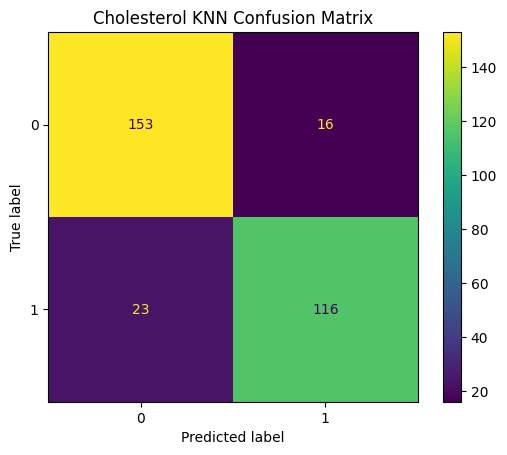

In [65]:
knn_conf_matrix = confusion_matrix(y_test, KNN_pred)
ConfusionMatrixDisplay(knn_conf_matrix, display_labels=knn.classes_).plot()
plt.title('Cholesterol KNN Confusion Matrix')
plt.show()